In [29]:
from datetime import date
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras import layers, Sequential,models
import tensorflow as tf

In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
google_stock = pd.read_csv("../data/LBMA-GOLD.csv").dropna(axis=0)  # 缺失值处理
print(google_stock.shape)
google_stock

(1255, 2)


,Date,USD (PM)
0,9/12/16,1324.60
1,9/13/16,1323.65
2,9/14/16,1321.75
3,9/15/16,1310.80
4,9/16/16,1308.35
...,...,...
1260,9/6/21,1821.60
1261,9/7/21,1802.15
1262,9/8/21,1786.00
1263,9/9/21,1788.25


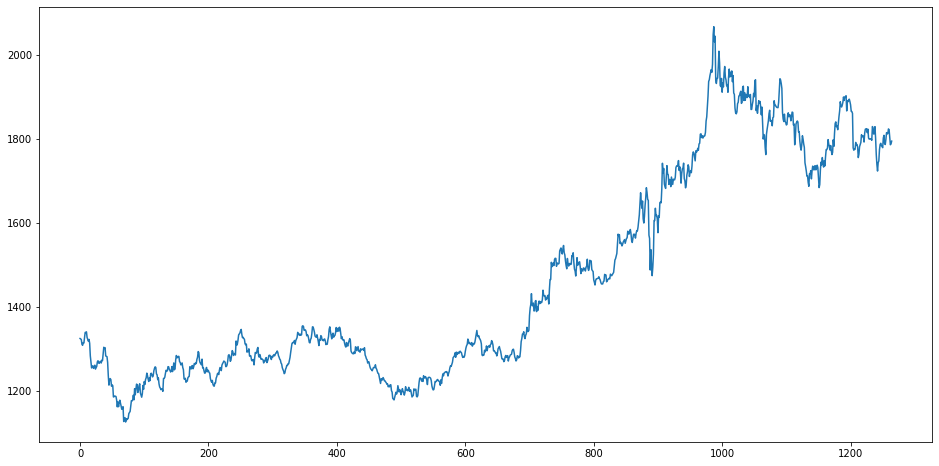

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['USD (PM)'])
plt.show()

### 数据预处理

In [33]:
# 时间点长度
time_stamp = 30

# 划分训练集与验证集
google_stock = google_stock[['USD (PM)']]  #  'Volume'

train = google_stock[0:900 + time_stamp]
print(f"train.shape:{train.shape}")
valid = google_stock[900 + time_stamp:]
print(f"valid.shape:{valid.shape}")

# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []


# 训练集构建
print(f"scaled_data.shape:{scaled_data.shape}")
print(f"scaled_data[0]:{scaled_data[0]}")
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# 验证集构建
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, 0])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# 总体数据集构建
scaled_data = scaler.fit_transform(google_stock)
x_total, y_total = [], []
for i in range(time_stamp, len(google_stock)):
    x_total.append(scaled_data[i - time_stamp:i])
    y_total.append(scaled_data[i, 0])

x_total, y_total = np.array(x_total), np.array(y_total)

print(f"x_train.shape:{x_train.shape}")
print(f"x_valid.shape{x_valid.shape}")
print(f"x_total.shape:{x_total.shape}")
train.head()

train.shape:(930, 1)
valid.shape:(325, 1)
scaled_data.shape:(930, 1)
scaled_data[0]:[0.31946675]
x_train.shape:(900, 30, 1)
x_valid.shape(295, 30, 1)
x_total.shape:(1225, 30, 1)


,USD (PM)
0,1324.60
1,1323.65
2,1321.75
3,1310.80
4,1308.35


### 模型构建

In [34]:
# 超参数
epochs = 30
batch_size = 16
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(layers.LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
57/57 [==============================] - 3s 13ms/step - loss: 0.0092
Epoch 2/30
57/57 [==============================] - 1s 13ms/step - loss: 0.0019
Epoch 3/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 4/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 5/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 6/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 7/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0014
Epoch 8/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 9/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 10/30
57/57 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 11/30
57/57 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 12/30
57/57 [==============================] - 1s 12ms/step - loss: 0.0010
Epoch 13/30
57/57 [==================

In [36]:
model.save("./trainedModel/LBMA-GOLD.h5")

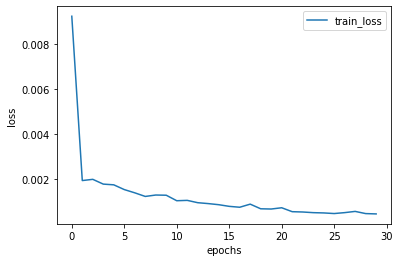

In [37]:
train_loss = history.history["loss"]


plt.plot(train_loss,label="train_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("../picture/loss_g.png")
plt.show()

### 测试集预测

In [38]:
x_valid_predict = model.predict(x_valid)
print(f"x_valid_predict.shape:{x_valid_predict.shape}")
scaler.fit_transform(pd.DataFrame(valid['USD (PM)'].values))
# 反归一化
x_valid_predict = scaler.inverse_transform(x_valid_predict)
y_valid = scaler.inverse_transform([y_valid])
rms = np.sqrt(np.mean(np.power((y_valid - x_valid_predict), 2)))
print(f"test_rms:{rms}")
print(f"x_valid_predict.shape:{x_valid_predict.shape}")
print(f"y_valid.shape{y_valid.shape}")

x_valid_predict.shape:(295, 1)
test_rms:101.16758378410476
x_valid_predict.shape:(295, 1)
y_valid.shape(1, 295)


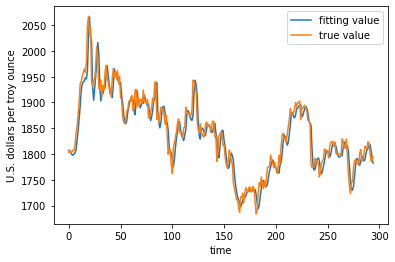

In [39]:
plt.plot(x_valid_predict.reshape(1,-1)[0],label="fitting value")
plt.plot(y_valid[0],label="true value")
plt.xlabel("time")
plt.ylabel("U.S. dollars per troy ounce")
plt.legend()
plt.savefig("../picture/fitting_g_test.png")
plt.show()

### 整体数据集上预测

In [40]:
x_total_predict = model.predict(x_total)

scaler.fit_transform(pd.DataFrame(google_stock['USD (PM)'].values))
# 反归一化
x_total_predict = scaler.inverse_transform(x_total_predict)
y_total = scaler.inverse_transform([y_total])
rms = np.sqrt(np.mean(np.power((y_total - x_total_predict), 2)))
print(f"test_rms:{rms}")
print(f"x_total_predict.shape:{x_total_predict.shape}")
print(f"y_total.shape{y_total.shape}")

test_rms:351.7112872834154
x_total_predict.shape:(1225, 1)
y_total.shape(1, 1225)


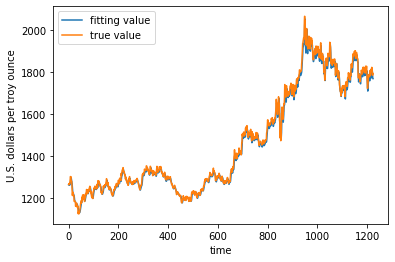

In [41]:
plt.plot(x_total_predict.reshape(1,-1)[0],label="fitting value")
plt.plot(y_total[0],label="true value")
plt.xlabel("time")
plt.ylabel("U.S. dollars per troy ounce")
plt.legend()
plt.savefig("../picture/fitting_g.png")
plt.show()

### 黄金的预测值保存和缺失值填充

In [42]:
predict = np.array([0 for i in range(30)] + list(x_total_predict[:,0]))
print(f"predict.shape:{predict.shape}")
df = pd.read_csv("../data/LBMA-GOLD.csv")
null_index = np.where(np.isnan(df['USD (PM)']))[0]
print(f"缺失值索引:{null_index}")

usd_predict = list(predict)
for index in null_index:
    usd_predict.insert(index,0.0)
    df.iloc[index,1] = 0.0
df["usd_nextday_predict"] = usd_predict
df.to_csv("../data/黄金预测数据.csv",index=False)

predict.shape:(1255,)
缺失值索引:[  74   77  326  329  579  582  832  835 1086 1089]


In [43]:
df

,Date,USD (PM),usd_nextday_predict
0,9/12/16,1324.60,0.000000
1,9/13/16,1323.65,0.000000
2,9/14/16,1321.75,0.000000
3,9/15/16,1310.80,0.000000
4,9/16/16,1308.35,0.000000
...,...,...,...
1260,9/6/21,1821.60,1807.020752
1261,9/7/21,1802.15,1807.719971
1262,9/8/21,1786.00,1790.944824
1263,9/9/21,1788.25,1771.256836


### 预测的黄金模型去预测比特币

In [44]:
google_stock = pd.read_csv("../data/BCHAIN-MKPRU.csv").dropna(axis=0)
print(google_stock.shape)
google_stock

(1826, 2)


,Date,Value
0,9/11/16,621.65
1,9/12/16,609.67
2,9/13/16,610.92
3,9/14/16,608.82
4,9/15/16,610.38
...,...,...
1821,9/6/21,51769.06
1822,9/7/21,52677.40
1823,9/8/21,46809.17
1824,9/9/21,46078.38


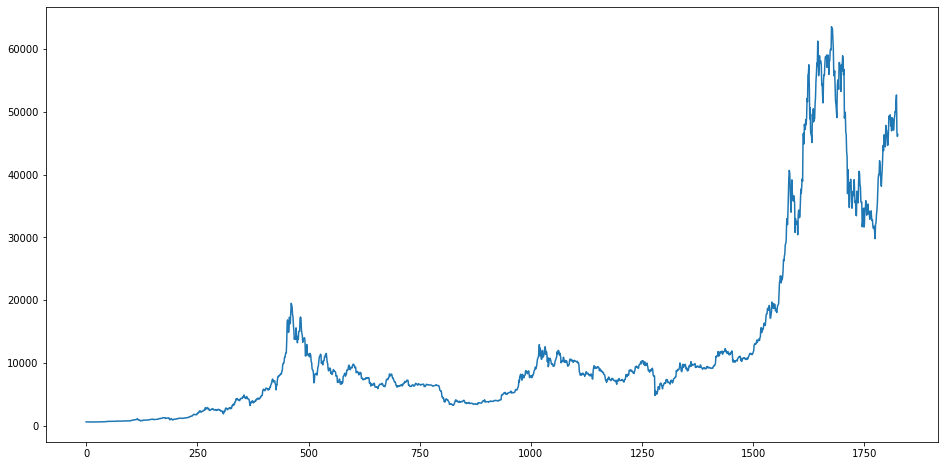

In [45]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['Value'])
plt.show()

In [46]:
# 时间点长度
time_stamp = 30

# 划分训练集与验证集
google_stock = google_stock[['Value']]  #  'Volume'

train = google_stock[0:1200 + time_stamp]
print(f"train.shape:{train.shape}")
valid = google_stock[1200 + time_stamp:]
print(f"valid.shape:{valid.shape}")

# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []


# 训练集构建
print(f"scaled_data.shape:{scaled_data.shape}")
print(f"scaled_data[0]:{scaled_data[0]}")
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# 验证集构建
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, 0])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# 总体数据集构建
scaled_data = scaler.fit_transform(google_stock)
x_total, y_total = [], []
for i in range(time_stamp, len(google_stock)):
    x_total.append(scaled_data[i - time_stamp:i])
    y_total.append(scaled_data[i, 0])

x_total, y_total = np.array(x_total), np.array(y_total)

print(f"x_train.shape:{x_train.shape}")
print(f"x_valid.shape{x_valid.shape}")
print(f"x_total.shape:{x_total.shape}")
train.head()

train.shape:(1230, 1)
valid.shape:(596, 1)
scaled_data.shape:(1230, 1)
scaled_data[0]:[0.00145837]
x_train.shape:(1200, 30, 1)
x_valid.shape(566, 30, 1)
x_total.shape:(1796, 30, 1)


,Value
0,621.65
1,609.67
2,610.92
3,608.82
4,610.38


### 测试集预测

In [47]:
x_valid_predict = model.predict(x_valid)
scaler.fit_transform(pd.DataFrame(valid['Value'].values))
# 反归一化
x_valid_predict = scaler.inverse_transform(x_valid_predict)
y_valid = scaler.inverse_transform([y_valid])
# print(y_valid)
# print(closing_price)
rms = np.sqrt(np.mean(np.power((y_valid - x_valid_predict), 2)))
print(f"test_rms:{rms}")
print(x_valid_predict.shape)
print(y_valid.shape)

test_rms:25100.172791357236
(566, 1)
(1, 566)


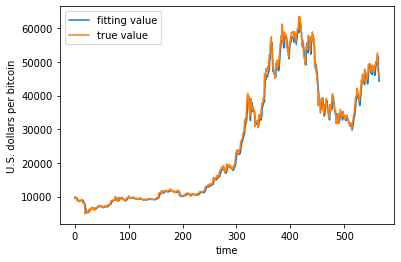

In [48]:
plt.plot(x_valid_predict.reshape(1,-1)[0],label="fitting value")
plt.plot(y_valid[0],label="true value")
plt.xlabel("time")
plt.ylabel("U.S. dollars per bitcoin")
plt.legend()
plt.savefig("../picture/fitting_b_test_using_gold_model.png")
plt.show()

### 总体数据预测

In [49]:
x_total_predict = model.predict(x_total)

scaler.fit_transform(pd.DataFrame(google_stock['Value'].values))
# 反归一化
x_total_predict = scaler.inverse_transform(x_total_predict)
y_total = scaler.inverse_transform([y_total])
rms = np.sqrt(np.mean(np.power((y_total - x_total_predict), 2)))
print(f"test_rms:{rms}")
print(f"x_total_predict.shape:{x_total_predict.shape}")
print(f"y_total.shape{y_total.shape}")

test_rms:19686.679596704907
x_total_predict.shape:(1796, 1)
y_total.shape(1, 1796)


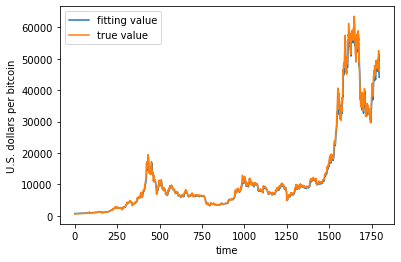

In [50]:
plt.plot(x_total_predict.reshape(1,-1)[0],label="fitting value")
plt.plot(y_total[0],label="true value")
plt.xlabel("time")
plt.ylabel("U.S. dollars per bitcoin")
plt.legend()
plt.savefig("../picture/fitting_b_using_gold_model.png")
plt.show()